# Analysis of output from Gremlin

All scores above 0 are taken compared with the WT pairs. All G,P,C -> X mutations are removed from the analysis to limit the number of mutations in the final combination.
The cutoff is computed as mean + 2*std 

In [1]:
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.graph_objs as go
import plotly.plotly as py
from ipywidgets import widgets
from IPython.display import display, clear_output, Image

In [2]:
inputfile = "test.txt"

In [3]:
# Getting the input amino acid sequence
aa_seq = ""
with open(inputfile,'r') as f:
    for line in f:
        if(len(line) > 1 and line[0:2] == "#S"):
           aa_seq = line.split()[1]

In [4]:
df = pd.read_csv(inputfile,skiprows=1,delim_whitespace=True)

In [5]:
covariance = {}
cutoff = 1
true_ = 0
for i,j in zip(df.index, df['##']):
    if( ( len(j.split("_")) ==  3)  & (j.split("_")[-1] == 'X') ):
        name = j+"_"+str(df.iloc[i,3])
        covariance[name] = {}
        true_ = 1
    elif(true_ == 1):
        tmpid = df.iloc[i,0]
        covariance[name][tmpid] = []
        covariance[name][tmpid] = list(df.iloc[i,1:])
        #covariance[name].append(tmpdict)
    else:
        continue

In [6]:
def get_lowest_scores(dataframe,key_w_aa):
    # position, WT, AA, score
    columns = ["WT","WT_Pos","AA_WT","AA_Pos","AA","GremlinScore","WTscore"]
    aa1,aa2,chain,score = key_w_aa.split("_")
    aa1 = int(aa1.lstrip("0"))
    aa2 = int(aa2.lstrip("0"))
    cutoff = dataframe.loc[aa_seq[aa1-1],aa_seq[aa2-1]]
    a = dataframe.loc[aa_seq[aa1-1], dataframe.loc[aa_seq[aa1-1],:] > cutoff]
    b = dataframe.loc[dataframe.loc[:,aa_seq[aa2-1]] > cutoff, aa_seq[aa2-1]]
    df = pd.DataFrame(index=range(0,len(a.index)+len(b.index)), columns=columns)
    dummy = 0
    for i in a.index:
        df.iloc[dummy,df.columns.get_loc("WT")] = aa_seq[aa1-1]
        df.iloc[dummy,df.columns.get_loc("WT_Pos")] = aa1
        df.iloc[dummy,df.columns.get_loc("AA_WT")] = aa_seq[aa2-1]
        df.iloc[dummy,df.columns.get_loc("AA")] = i
        df.iloc[dummy,df.columns.get_loc("AA_Pos")] = aa2
        df.iloc[dummy,df.columns.get_loc("GremlinScore")] = a[i]
        df.iloc[dummy,df.columns.get_loc("WTscore")] = cutoff
        dummy += 1
        
    for i in b.index:
        df.iloc[dummy,df.columns.get_loc("WT")] = aa_seq[aa2-1]
        df.iloc[dummy,df.columns.get_loc("WT_Pos")] = aa2
        df.iloc[dummy,df.columns.get_loc("AA_WT")] = aa_seq[aa1-1]
        df.iloc[dummy,df.columns.get_loc("AA")] = i
        df.iloc[dummy,df.columns.get_loc("AA_Pos")] = aa1
        df.iloc[dummy,df.columns.get_loc("GremlinScore")] = b[i]
        df.iloc[dummy,df.columns.get_loc("WTscore")] = cutoff
        dummy += 1
    return df
                    
    

In [7]:
dfs = []
# loop over all the keys
for key in covariance.keys():
    if( float(key.split('_')[-1]) >  0.99 ):
        tmpdf = pd.DataFrame.from_dict(covariance[key], orient='index',columns=["A","F","I","L","V","M","W","Y","D","E","K","R","H","N","Q","S","T","G","P","C"])
        tmpdf.index = ["A","F","I","L","V","M","W","Y","D","E","K","R","H","N","Q","S","T","G","P","C"]
        dfs.append( get_lowest_scores(tmpdf,key) )
dftot = pd.concat(dfs)
dftot.reset_index(inplace=True)

In [8]:
dftot["Diff_score"] = dftot["GremlinScore"] - dftot["WTscore"]

In [9]:
# remove all G,P,C -> X
dftot = dftot[(dftot["AA_WT"] != 'G') & (dftot["AA_WT"] != 'P') & \
                               (dftot["AA"] != 'G') & (dftot["AA"] != 'C')]

In [10]:
dftot.head()

,index,WT,WT_Pos,AA_WT,AA_Pos,AA,GremlinScore,WTscore,Diff_score
38,0,K,241,S,254,T,2.11,1.65,0.46
39,0,E,256,K,328,R,1.32,1.04,0.28
40,1,E,256,K,328,H,1.43,1.04,0.39
42,0,I,232,A,258,F,0.28,-0.3,0.58
43,1,I,232,A,258,I,0.67,-0.3,0.97


In [11]:
dftot = dftot[dftot["GremlinScore"] > 0]

In [12]:
dftot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 38 to 744
Data columns (total 9 columns):
index           482 non-null int64
WT              482 non-null object
WT_Pos          482 non-null object
AA_WT           482 non-null object
AA_Pos          482 non-null object
AA              482 non-null object
GremlinScore    482 non-null object
WTscore         482 non-null object
Diff_score      482 non-null object
dtypes: int64(1), object(8)
memory usage: 37.7+ KB


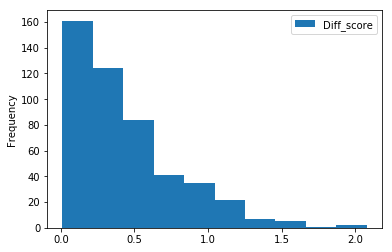

In [13]:
dftot.plot(y="Diff_score",kind='hist')

In [14]:
cutoff = dftot["Diff_score"].mean()+2*dftot["Diff_score"].std()

In [15]:
dftot = dftot[dftot["Diff_score"] > cutoff]
dftot.sort_values(by="GremlinScore",ascending=False).head(30)

,index,WT,WT_Pos,AA_WT,AA_Pos,AA,GremlinScore,WTscore,Diff_score
157,16,P,23,L,22,T,1.94,-0.08,2.02
171,4,D,336,S,340,R,1.74,0.06,1.68
678,11,P,65,A,183,H,1.72,-0.36,2.08
84,5,R,67,V,14,E,1.68,0.29,1.39
494,5,W,263,V,278,S,1.51,-0.15,1.66
103,14,K,425,T,228,E,1.5,0,1.5
130,1,F,151,V,157,S,1.5,0.16,1.34
235,4,K,224,L,418,E,1.48,-0.09,1.57
469,9,S,302,M,286,N,1.39,0.11,1.28
129,0,F,151,V,157,A,1.38,0.16,1.22


In [16]:
print("Unique positions: ",len(dftot["WT_Pos"].unique()) )

Unique positions:  18


In [17]:
# write to muts.txt
with open("muts.txt", 'w') as f:
    for i,j,k in zip(dftot.AA_WT, dftot.AA_Pos,dftot.AA):
        f.write(i+str(j)+k+'\n')

In [18]:
# generate mutation file for ddG cartesian
header="total 1\n1\n"
for i,j,k in zip(dftot.AA_WT, dftot.AA_Pos,dftot.AA):
    with open(i+str(j)+k+".mutfile",'w') as f:
        f.write(header)
        f.write(i+" "+str(j)+" "+k)